In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import seaborn as sns
import matplotlib. pyplot as plt
import numpy as np
from datetime import datetime, timedelta

Загрузим нужные файлы с яндекс диска

In [2]:
olist_customers_dataset = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
olist_orders_dataset = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
olist_order_items_dataset = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [3]:
def download(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
customers = pd.read_csv(download(olist_customers_dataset))
orders = pd.read_csv(download(olist_orders_dataset))
products = pd.read_csv(download(olist_order_items_dataset))

KeyError: 'href'

In [ ]:
customers.head()

In [ ]:
customers.dtypes

In [ ]:
orders.head()

In [ ]:
orders.dtypes

In [ ]:
products.head()

In [ ]:
products.dtypes

Видим, что все даты строчного формата. Меняем на тип даты.

In [ ]:
columns = ['order_purchase_timestamp', 
          'order_approved_at', 
          'order_delivered_carrier_date', 
          'order_delivered_customer_date', 
          'order_estimated_delivery_date']
orders[columns] = orders[columns].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

In [ ]:
products['shipping_limit_date'] = pd.to_datetime(products['shipping_limit_date'], format='%Y-%m-%d')

Для начала работы над данными нужно определить, что для нас является покупкой. Посмотрим на статусы заказов.

Уникальные статусы заказов в таблице olist_orders_dataset:
created — создан
approved — подтверждён
invoiced — выставлен счёт
processing — в процессе сборки заказа
shipped — отгружен со склада
delivered — доставлен пользователю
unavailable — недоступен
canceled — отменён

In [ ]:
orders.order_status.value_counts()

Я считаю, и думаю так будет логично, оставит заказы со статусом delivered (доставлен пользователю, а значит произошла покупка и соответственно оплата).
Проверим эти заказы на их оплату и на доставку.

In [ ]:
orders.query("order_status == 'delivered'").order_approved_at.isna().sum() #14 заказов не оплачены

In [ ]:
orders.query("order_status == 'delivered'")[orders.query("order_status == 'delivered'").order_approved_at.isna()]

In [ ]:
orders.query("order_status == 'delivered'").order_delivered_customer_date.isna().sum() #8 заказов не имеют даты доставки

In [ ]:
orders.query("order_status == 'delivered'")[orders.query("order_status == 'delivered'").order_delivered_customer_date.isna()]

14 заказов без даты оплаты включаем в покупку, т.к. они имеют статус delivered и дату доставки.
8 заказов, по которым нет даты доставки, будем считать покупкой, они тоже имеют статус delivered и все оплачены. 
Будем считать, что произошёл сбой в системе данных или просто забыли внести данные.
Получается, что покупкой считаются те заказы, которые имеют статус delivered (96478 заказов).

In [5]:
orders.query("order_status == 'delivered'").shape

NameError: name 'orders' is not defined

1. Сколько у нас пользователей, которые совершили покупку только один раз?

Объединяем таблицы customers и orders

In [6]:
customers_orders = customers.merge(orders, on='customer_id')

NameError: name 'customers' is not defined

In [40]:
orders.shape[0] == customers.shape[0]

True

In [41]:
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [42]:
one_customer = customers_orders \
            .query("order_status == 'delivered'") \
            .groupby('customer_unique_id', as_index=False) \
            .agg({'order_id': 'count'}) \
            .query('order_id == 1')

In [43]:
one_customer.customer_unique_id.count()
# 90557 пользователей совершили покупку только один раз

90557

In [44]:
customers_orders.customer_unique_id.nunique()
# 96096 всего пользователей

96096

In [45]:
90557 / 96096 * 100

94.23597236097237

Вывод: только 6% пользователей совершили повторный заказ на данном сайте, это достаточно маленький процент.
Можем предположить, что предлагается не часто покупаемый или сезонный товар.

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Проведём анализ по товарам, которые не доставляются. Для этого выведим в новую колонку год и месяц ожидаемой даты доставки

In [49]:
index_estimated_date = customers_orders.set_index('order_estimated_delivery_date')

In [50]:
estimated_date = index_estimated_date.assign(date = lambda x: pd.to_datetime(x.index).strftime('%Y-%m'))

In [51]:
estimated_date.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,date
order_estimated_delivery_date,,,,,,,,,,,,
2017-06-05,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06
2018-02-06,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02
2018-06-13,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06
2018-04-10,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04
2018-08-15,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08


In [52]:
order_not_delivered = estimated_date \
                            .query("order_status != 'delivered'") \
                            .groupby(['date', 'order_status'], as_index=False) \
                            .agg({'order_id': 'count'}) \
                            .rename(columns={'order_id': 'orders'}) \
                            .groupby('order_status', as_index=False) \
                            .agg({'orders': 'mean'}) \
                            .round(2) \
                            .sort_values('orders')

In [53]:
order_not_delivered #среднее число недоставленных в месяц по статусам

,order_status,orders
0,approved,1.00
2,created,1.67
3,invoiced,14.95
4,processing,15.84
1,canceled,24.04
6,unavailable,29.00
5,shipped,48.13


In [54]:
order_not_delivered.orders.mean().round(2) # почти 20 заказов в месяц в среднем не доставляется

19.23

Посмотрим на распределение среднего числа недоставленных в месяц по статусам

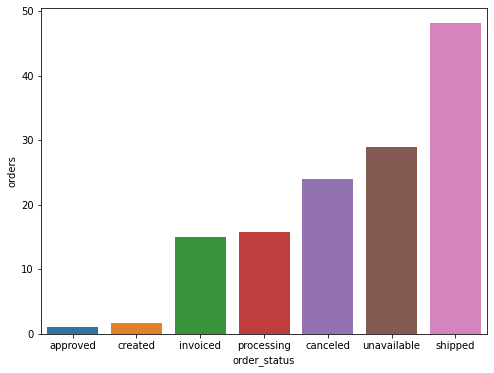

In [56]:
plt.figure(figsize=(8,6))
sns.barplot(data=order_not_delivered, x='order_status', y='orders')

Т.к. мы посчитали, что доставленным считается только заказ со статусом delivered, значит остальные статусы можно рассматривать, как причинами недоставленного заказа.
Заказы unavailable и canceled будут считаться явной причиной, а товары с остальными статусами являются недоставленными на данный момент, т.к. не прошли полный путь логистики

3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

Объединяем таблицы orders и products

In [60]:
orders_products = orders.merge(products, on='order_id')

In [61]:
orders.shape[0] == products.shape[0]

False

В таблице с данным о товарах больше строк, т.к. в одном заказе может быть несколько товаров. На наш анализ в этом задании это не повлияет, поэтому оставляем как есть.

In [63]:
orders_products.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [64]:
index_order_purchase = orders_products.set_index('order_purchase_timestamp')

In [65]:
order_purchase = index_order_purchase.assign(weekday = lambda x: pd.to_datetime(x.index).strftime('%A'))

In [66]:
order_purchase.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weekday
order_purchase_timestamp,,,,,,,,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [67]:
count_product_weekday = order_purchase \
                        .query("order_status == 'delivered'") \
                        .groupby(['product_id', 'weekday'], as_index=False) \
                        .size() \
                        .sort_values('size', ascending=False)

In [68]:
count_product_weekday.head()

,product_id,weekday,size
15597,422879e10f46682990de24d770e7f83d,Wednesday,93
35751,99a4788cb24856965c36a24e339b6058,Monday,91
40183,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40184,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
40179,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,83


Определили по каждому товару, в какой день недели товар чаще всего покупается

In [70]:
count_weekday = order_purchase \
                .query("order_status == 'delivered'") \
                .groupby('weekday', as_index=False) \
                .size() \
                .sort_values('size', ascending=False)

In [71]:
count_weekday

,weekday,size
1,Monday,17973
5,Tuesday,17858
6,Wednesday,17219
4,Thursday,16434
0,Friday,15698
3,Sunday,13130
2,Saturday,11885


Также посчитали сколько товаров покупается в каждый день недели и оторбразили на графике

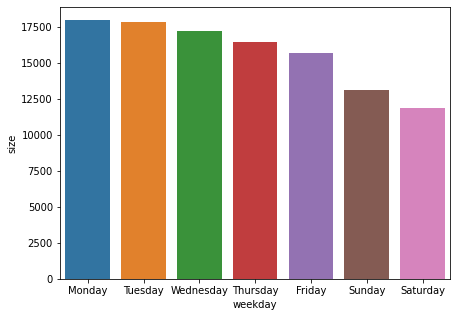

In [73]:
plt.figure(figsize=(7,5))
sns.barplot(x='weekday', y='size', data=count_weekday)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [75]:
customers_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [76]:
index_order_purchase_date = customers_orders.set_index('order_purchase_timestamp')

In [77]:
order_purchase_month = index_order_purchase_date.assign(month = lambda x: pd.to_datetime(x.index).strftime('%m'))

In [78]:
order_purchase_month.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
order_purchase_timestamp,,,,,,,,,,,,
2017-05-16 15:05:35,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,05
2018-01-12 20:48:24,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,01
2018-05-19 16:07:45,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,05
2018-03-13 16:06:38,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,03
2018-07-29 09:51:30,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,07


In [79]:
#Посчитаем количество заказов для каждого пользователя по месяцам
order_month = order_purchase_month.groupby(['customer_id', 'month'], as_index=False).agg({'order_id': 'count'})

In [80]:
order_month.head()

,customer_id,month,order_id
0,00012a2ce6f8dcda20d059ce98491703,11,1
1,000161a058600d5901f007fab4c27140,07,1
2,0001fd6190edaaf884bcaf3d49edf079,02,1
3,0002414f95344307404f0ace7a26f1d5,08,1
4,000379cdec625522490c315e70c7a9fb,04,1


Посчитаем сколько недель в каждом месяце

In [82]:
weeks = []
for i in order_month.month:
    if i == '01' or i == '03' or i == '05' or i == '07' or i == '08' or i == '10' or i == '12':
        weeks.append(4.43)
    elif i == '04' or i == '06' or i == '09' or i == '11':
        weeks.append(4.29)
    elif i == '02':
        weeks.append(4)
    else: 
        continue

In [83]:
order_month['weeks'] = weeks

In [84]:
order_month.head()

,customer_id,month,order_id,weeks
0,00012a2ce6f8dcda20d059ce98491703,11,1,4.29
1,000161a058600d5901f007fab4c27140,07,1,4.43
2,0001fd6190edaaf884bcaf3d49edf079,02,1,4.00
3,0002414f95344307404f0ace7a26f1d5,08,1,4.43
4,000379cdec625522490c315e70c7a9fb,04,1,4.29


In [85]:
order_month['order_week'] = order_month.order_id / order_month.weeks

In [86]:
order_month['order_week'] = order_month.order_week.round(2)

In [90]:
order_month.head()

,customer_id,month,order_id,weeks,order_week
0,00012a2ce6f8dcda20d059ce98491703,11,1,4.29,0.23
1,000161a058600d5901f007fab4c27140,07,1,4.43,0.23
2,0001fd6190edaaf884bcaf3d49edf079,02,1,4.00,0.25
3,0002414f95344307404f0ace7a26f1d5,08,1,4.43,0.23
4,000379cdec625522490c315e70c7a9fb,04,1,4.29,0.23


Колонка order_week показывает, сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 

Определим четыре основных параметра когорты:
Признак формирования когорты - первый заказ
Размер когорты (временной интервал) - месяц
Отчетный период — 2017 г.
Анализируемый ключевой показатель - Retention Rate

В наших данных полный год со всеми месяцами — только 2017-й. Поэтому для когортного анализа возьмем пользователей, которые совершили первый заказ в 2017-м году.

Для анализа будем использовать таблицу customers_orders, отсортируем дату и отберем только успешные заказы

In [110]:
index_order_purchase_date = customers_orders.set_index('order_purchase_timestamp')

In [111]:
order_purchase_date = index_order_purchase_date.assign(date_order = lambda x: pd.to_datetime(x.index).strftime('%Y-%m'))

In [112]:
delivered_2017 = order_purchase_date.query("date_order >= '2017-01' and date_order < '2018-01' and order_status == 'delivered'")

In [113]:
delivered_2017.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,date_order
order_purchase_timestamp,,,,,,,,,,,,
2017-05-16 15:05:35,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
2017-09-14 18:14:31,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09
2017-11-16 19:29:02,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-11
2017-11-27 17:23:20,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-11
2017-09-09 09:54:57,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,2017-09


Находим дату первого заказа каждого пользователя

In [118]:
first_order.head()

,customer_unique_id,date_first_order
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07


Отбираем уникальные даты заказов, чтобы посмотреть активность каждого пользователя по месяцам 

In [119]:
month = pd.DataFrame(delivered_2017.date_order.unique())

In [120]:
month = month.rename(columns={0: 'month'}).sort_values('month')

In [121]:
month

,month
8,2017-01
11,2017-02
10,2017-03
5,2017-04
0,2017-05
6,2017-06
9,2017-07
3,2017-08
1,2017-09
4,2017-10


In [122]:
#Присвоим ключи для соединения таблиц
first_order['key'] = 1
month['key'] = 1

In [124]:
template = first_order.merge(month, on='key')[['customer_unique_id', 'date_first_order', 'month']]

Отбросим месяца, которые предшествуют первому заказу пользователя, т.к. по ним будут пустые значения

In [126]:
template = template[template['month'] >= template['date_first_order']]

In [127]:
template

,customer_unique_id,date_first_order,month
2,0000f46a3911fa3c0805444483337064,2017-03,2017-03
3,0000f46a3911fa3c0805444483337064,2017-03,2017-04
4,0000f46a3911fa3c0805444483337064,2017-03,2017-05
5,0000f46a3911fa3c0805444483337064,2017-03,2017-06
6,0000f46a3911fa3c0805444483337064,2017-03,2017-07
...,...,...,...
505627,ffffd2657e2aad2907e67c3e9daecbeb,2017-05,2017-08
505628,ffffd2657e2aad2907e67c3e9daecbeb,2017-05,2017-09
505629,ffffd2657e2aad2907e67c3e9daecbeb,2017-05,2017-10
505630,ffffd2657e2aad2907e67c3e9daecbeb,2017-05,2017-11


Смотрим, когда у пользователя был повторный заказ и считаем сколько их было

In [129]:
reorder = delivered_2017 \
            .groupby(['customer_unique_id', 'date_order'], as_index=False) \
            .agg({'order_id': 'count'}) \
            .rename(columns={'date_order': 'month'})

In [130]:
reorder.head()

,customer_unique_id,month,order_id
0,0000f46a3911fa3c0805444483337064,2017-03,1
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
2,0004aac84e0df4da2b147fca70cf8255,2017-11,1
3,0005e1862207bf6ccc02e4228effd9a0,2017-03,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07,1


Объединяем две таблицы через 'left' для того, чтобы видеть, когда пользователь ничего не покупает
И строим сводную таблицу, в которй будет видно % активных пользователей по месяцам

In [132]:
cohort = template.merge(reorder, on=['customer_unique_id', 'month'], how='left')

In [133]:
cohort['date_first_order'] = pd.to_datetime(cohort.date_first_order)

In [134]:
cohort['month'] = pd.to_datetime(cohort.month)

In [137]:
cohort.head()

,customer_unique_id,date_first_order,month,order_id
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN


In [157]:
cohort_table1 = cohort.pivot_table(index='date_first_order', columns='month', values='order_id', aggfunc='mean')

In [158]:
cohort_table1

month,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01
date_first_order,,,,,,,,,,,,
2017-01-01,1.044568,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000
2017-02-01,NaN,1.014128,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-03-01,NaN,NaN,1.015182,1.090909,1.000000,1.20000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-04-01,NaN,NaN,NaN,1.012406,1.071429,1.20000,1.250000,1.000000,1.000000,1.125000,1.000000,1.000000
2017-05-01,NaN,NaN,NaN,NaN,1.019125,1.06250,1.000000,1.000000,1.000000,1.090909,1.142857,1.000000
2017-06-01,NaN,NaN,NaN,NaN,NaN,1.01811,1.066667,1.083333,1.000000,1.111111,1.000000,1.000000
2017-07-01,NaN,NaN,NaN,NaN,NaN,NaN,1.018119,1.100000,1.000000,1.000000,1.181818,1.000000
2017-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.018733,1.035714,1.142857,1.000000,1.000000
2017-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.016479,1.000000,1.000000,1.363636


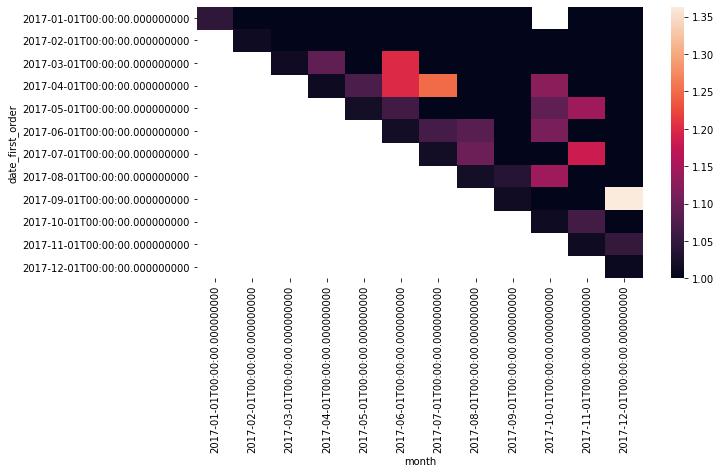

In [159]:
#Визуализируем полученные данные
plt.figure(figsize=(10, 5))
ax = sns.heatmap(cohort_table1)

Cделаем еще одну сводную таблицу, в которой посмотрим на активность каждого клиента на протяжении отчетного периода

In [169]:
cohort['month_distance'] = ((cohort['month'] - cohort['date_first_order']) / np.timedelta64(1, 'M')).round()

In [170]:
cohort.head()

,customer_unique_id,date_first_order,month,order_id,month_distance
0,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,1.0,0.0
1,0000f46a3911fa3c0805444483337064,2017-03-01,2017-04-01,NaN,1.0
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-05-01,NaN,2.0
3,0000f46a3911fa3c0805444483337064,2017-03-01,2017-06-01,NaN,3.0
4,0000f46a3911fa3c0805444483337064,2017-03-01,2017-07-01,NaN,4.0


In [179]:
cohort_table2 = cohort.pivot_table(index='date_first_order', columns='month_distance', values='order_id', aggfunc='count')

In [180]:
cohort_table2

month_distance,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
date_first_order,,,,,,,,,,,,
2017-01-01,718.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0
2017-02-01,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03-01,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,NaN,NaN
2017-04-01,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05-01,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,NaN,NaN,NaN,NaN
2017-06-01,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,3753.0,20.0,13.0,9.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,4057.0,28.0,14.0,11.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,4005.0,28.0,22.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


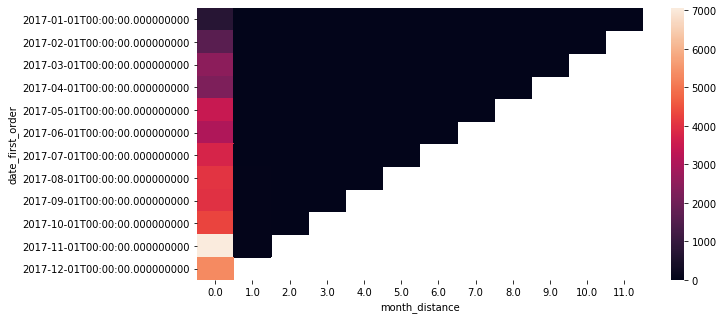

In [181]:
#Тоже посмотрим на график
plt.figure(figsize=(10, 5))
ax = sns.heatmap(cohort_table2)

Чтобы посчитать retention rate, нам нужно количество заказов в процентах от первоначальных данных когорты.

In [183]:
cohort_table_percent = cohort_table2.divide(cohort_table2[0], axis=0)
del cohort_table_percent[0] #удаляем первую колонку, чтобы не искажать цветовой график

In [184]:
cohort_table_percent

month_distance,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
date_first_order,,,,,,,,,,,
2017-01-01,0.002786,0.002786,0.001393,0.004178,0.001393,0.004178,0.001393,0.001393,0.000000,0.004178,0.001393
2017-02-01,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,NaN
2017-03-01,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,NaN,NaN
2017-04-01,0.006203,0.002215,0.001772,0.002658,0.002658,0.003545,0.003101,0.003101,NaN,NaN,NaN
2017-05-01,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449,NaN,NaN,NaN,NaN
2017-06-01,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,NaN,NaN,NaN,NaN,NaN
2017-07-01,0.005329,0.003464,0.002398,0.002931,0.002132,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,0.006902,0.003451,0.002711,0.003451,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,0.006991,0.005493,0.002747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


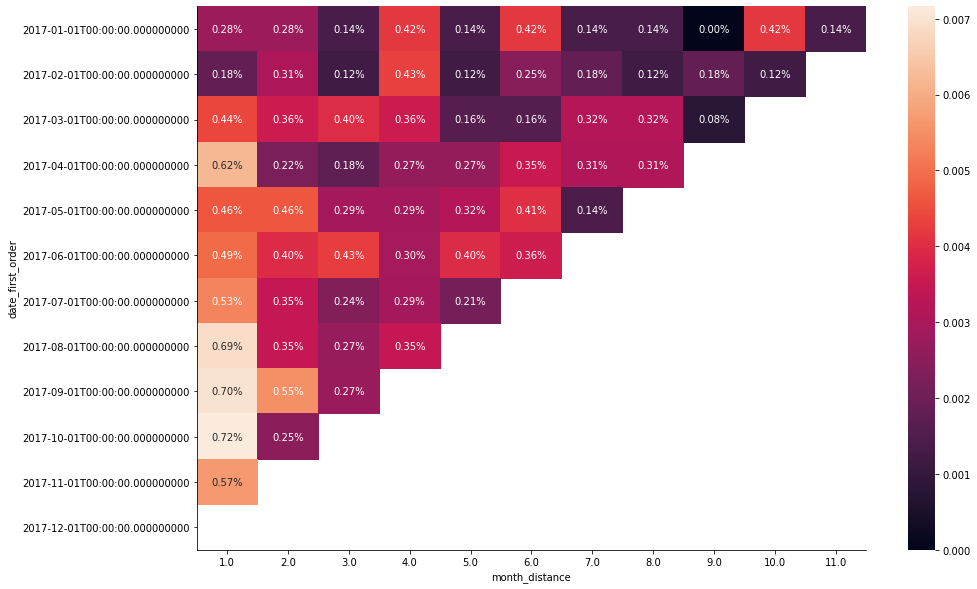

In [186]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(cohort_table_percent, annot=True, fmt='.2%')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
sns.despine()

Согласно полученному графику, самый высокий retention на 3-й месяц покупки у когорты 2017-06 - 0.43%.

6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

Для анализа объединим все три таблицы с первоночальными данными, с колонки времени создания заказа оставим только дату и отберем только успешные заказы.
Обычно используемым значением в сегментации RFM является один год, а т.к. у нас только 2017 год со всеми месяцами, то будем считать его отчетным.

In [208]:
df = customers_orders.merge(products, on='order_id')

In [209]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [210]:
index_order_purchase_date = df.set_index('order_purchase_timestamp')

In [211]:
order_purchase_date = index_order_purchase_date.assign(date = lambda x: pd.to_datetime(x.index).strftime('%Y-%m-%d'))

In [212]:
order_purchase_date = order_purchase_date.query("date >= '2017-01-01' and date < '2018-01-01' and order_status == 'delivered'")

In [213]:
order_purchase_date.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,date
order_purchase_timestamp,,,,,,,,,,,,,,,,,,
2017-05-16 15:05:35,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05-16
2017-09-14 18:14:31,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,1,0be701e03657109a8a4d5168122777fb,8f2ce03f928b567e3d56181ae20ae952,2017-09-20 18:25:11,259.90,22.31,2017-09-14
2017-11-16 19:29:02,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,1,124f74f703e88efe001a10bfa718b6ff,2a7dc43cecabf23403078e2188437d1d,2017-11-22 19:55:41,19.90,16.11,2017-11-16
2017-11-27 17:23:20,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,1,6b874ff4c71d18e91079b40396bf176a,b6e1504972665f739dec4facb9943775,2017-12-01 18:01:20,25.30,15.10,2017-11-27
2017-09-09 09:54:57,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,1,3fc00af0f0a8d4ac2933d3900416c977,7a241947449cc45dbfda4f9d0798d9d0,2017-09-14 10:10:17,99.00,18.31,2017-09-09


Посчитаем, сколько потратил каждый потребитель на совершенные заказы

In [221]:
orders = order_purchase_date \
        .groupby(['order_id', 'date', 'customer_unique_id'], as_index=False) \
        .agg({'price': lambda x: x.sum()})

In [222]:
orders.head()

,order_id,date,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.9
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26,eb28e67c4c0b83846050ddfb8a35d051,239.9
2,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04,64b576fb70d441e8f1b2d7d446e483c5,199.9
3,00048cc3ae777c65dbb7d2a0634bc1ea,2017-05-15,85c835d128beae5b4ce8602c491bf385,21.9
4,00054e8431b9d7675808bcb819fb4a32,2017-12-10,635d9ac1680f03288e72ada3a1035803,19.9


In [227]:
orders['date'] = pd.to_datetime(orders.date)

In [232]:
now_date = orders['date'].max() + timedelta(days=1) #к последней дате прибавили один день для подсчета недавности заказа

In [233]:
now_date

Timestamp('2018-01-01 00:00:00')

In [234]:
orders['date_difference'] = orders['date'].apply(lambda x: (now_date - x).days) #расчитываем недавность заказа в днях

In [235]:
orders.head()

,order_id,date,customer_unique_id,price,date_difference
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.9,110
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26,eb28e67c4c0b83846050ddfb8a35d051,239.9,250
2,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04,64b576fb70d441e8f1b2d7d446e483c5,199.9,331
3,00048cc3ae777c65dbb7d2a0634bc1ea,2017-05-15,85c835d128beae5b4ce8602c491bf385,21.9,231
4,00054e8431b9d7675808bcb819fb4a32,2017-12-10,635d9ac1680f03288e72ada3a1035803,19.9,22


In [236]:
period = 365 #мы отобрали ровно год, поэтому период будет равен 365 дней

Расчитываем частоту заказов у каждого пользователя

In [237]:
frequency = {
    'date_difference': lambda x: x.min(),
    'date': lambda x: len([d for d in x if d >= now_date - timedelta(days=period)]),
}
rfm = orders.groupby('customer_unique_id').agg(frequency).reset_index()
rfm.rename(columns={'date_difference': 'Recency', 'date': 'Frequency'}, inplace=True)
rfm.head()

,customer_unique_id,Recency,Frequency
0,0000f46a3911fa3c0805444483337064,297,1
1,0000f6ccb0745a6a4b88665a16c9f078,81,1
2,0004aac84e0df4da2b147fca70cf8255,48,1
3,0005e1862207bf6ccc02e4228effd9a0,303,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1


Теперь добавляем сумму денег, потраченную каждым пользователем

In [239]:
rfm['Monetary'] = rfm['customer_unique_id'].apply(lambda x: orders[(orders['customer_unique_id'] == x) & \
                                                           (orders['date'] >= now_date - timedelta(days=period))]\
                                                           ['price'].sum())
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,297,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,303,1,135.00
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90


На данный момент мы рассчитали значения параметров Recency, Frequency и Monetary для каждого пользователя, где Recency - время от последней покупки пользователя до текущей даты, Frequency - частота совершения покупок пользователем за год, Monetary - денежная сумма покупок пользователя за год.
Далее с помощью метода квинтилей, разобьем полученные данные о пользователях на диапазоны

In [241]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.4, .8]).to_dict()
quintiles

{'Recency': {0.4: 92.0, 0.8: 231.0},
 'Frequency': {0.4: 1.0, 0.8: 1.0},
 'Monetary': {0.4: 68.8, 0.8: 179.9}}

Затем присваиваем ранги от 1 до 3 по полученным диапазонам. Чем меньше значение 'недавности', тем лучше, тогда как более высокие значения 'частоты' и 'денег' лучше. Поэтому создаем две функции. 

In [243]:
def r_score(x):
    if x <= quintiles['Recency'][.4]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.4]:
        return 1
    elif x <= quintiles[c][.8]:
        return 2
    else:
        return 3

Добавляем данные в таблицу

In [245]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

И выводим полученную RFM-сегментацию пользователей

In [247]:
rfm['RFM_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_score
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,2,112
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,3,1,1,311
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,3,1,3,313
3,0005e1862207bf6ccc02e4228effd9a0,303,1,135.00,1,1,2,112
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211


С помощью функции делим пользователей на соответствующие сегменты

Сегменты и их описание:
111, 112, 113 - Потерянные (Скорее всего, эти клиенты уже ушли от нас, и не стоит тратить слишком больших усилий на этот сегмент)
121, 122, 123 - Уходящие (Cделали несколько покупок, а потом перестали покупать, их можно попытаться вернуть)
131, 132, 133 - Уходящие хорошие (Этих клиентов обязательно нужно попытаться вернуть, предлагаем бонусы, программы лояльности)
211, 212, 213, 221, 222, 223 - Спящие редкие (Эти клиенты ещё помнят о нас, отправляем им рассылки с интересными акциями и выгодными предложениями)
231, 222, 223 - Спящие постоянные (Ещё не так давно они часто покупали, а сейчас перестали. Нужно узнать, в чём дело, и попытаться вернуть их. Отправляем им рассылку с интересными акциями и рассылку с опросом)
311, 312 - Новички (Отправялем welcome-рассылку с описанием преимуществ, ответами на частые вопросы, материалы по работе с сайтом)
313 - Новички с высоким чеком (Потенциальные VIP. В дополнение к welcome-рассылке отправляем им интересное предложение)
321, 322, 331 - Постоянные с маленьким чеком (Нужно попытаться увеличить средний чек допродажей. Отправляем им рассылки с сопутствующими товарами)
323 - Постоянные с высоким чеком (Эти клиенты и так хорошо покупают, отправляем только основные рассылки)
332 - Постоянные со средним чеком (Самые хорошие клиенты, можно попробовать увеличить сумму чека. Отправляем им специальные предложения, сопутствующие товары)
333 - VIP (Отправялем им особые предложения, например, участие в программе лояльности — приглашение в клуб любимых клиентов)

In [250]:
def rfm_score(x):
    if x == '111' or x == '112' or x == '113':
        return 'Потерянные'
    elif x == '121' or x == '122' or x == '123':
        return 'Уходящие'
    elif x == '131' or x == '132' or x == '133':
        return 'Уходящие хорошие'
    elif x == '211' or x == '212' or x =='213' or x == '221' or x == '222' or x == '223':
        return 'Спящие редкие'
    elif x == '231' or x == '222' or x == '223':
        return 'Спящие постоянные'
    elif x == '311' or x == '312':
        return 'Новички'
    elif x == '313':
        return 'Новички с высоким чеком'
    elif x == '321' or x == '322' or x == '331':
        return 'Постоянные с маленьким чеком'
    elif x == '323':
        return 'Постоянные с высоким чеком'
    elif x == '332':
        return 'Постоянные со средним чеком'
    else:
        return 'VIP'

In [251]:
rfm['Segment'] = rfm['RFM_score'].apply(lambda x: rfm_score(x))
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_score,Segment
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,2,112,Потерянные
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,3,1,1,311,Новички
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,3,1,3,313,Новички с высоким чеком
3,0005e1862207bf6ccc02e4228effd9a0,303,1,135.00,1,1,2,112,Потерянные
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211,Спящие редкие


Посмотрим на распределение наших пользователей

In [253]:
segment_count = pd.DataFrame(rfm.Segment
                             .value_counts('normalize')
                             .sort_values(ascending=True)
                             .reset_index()
                             .rename(columns={'Segment': 'Count', 'index': 'Segment'}))

In [254]:
segment_count['Count'] = segment_count.Count * 100

In [255]:
segment_count['Count'] = segment_count.Count.round(2)

In [256]:
segment_count

,Segment,Count
0,Спящие постоянные,0.10
1,Постоянные с маленьким чеком,0.11
2,Уходящие хорошие,0.37
3,Постоянные со средним чеком,0.51
4,VIP,1.68
5,Новички с высоким чеком,7.44
6,Потерянные,19.58
7,Новички,31.58
8,Спящие редкие,38.62


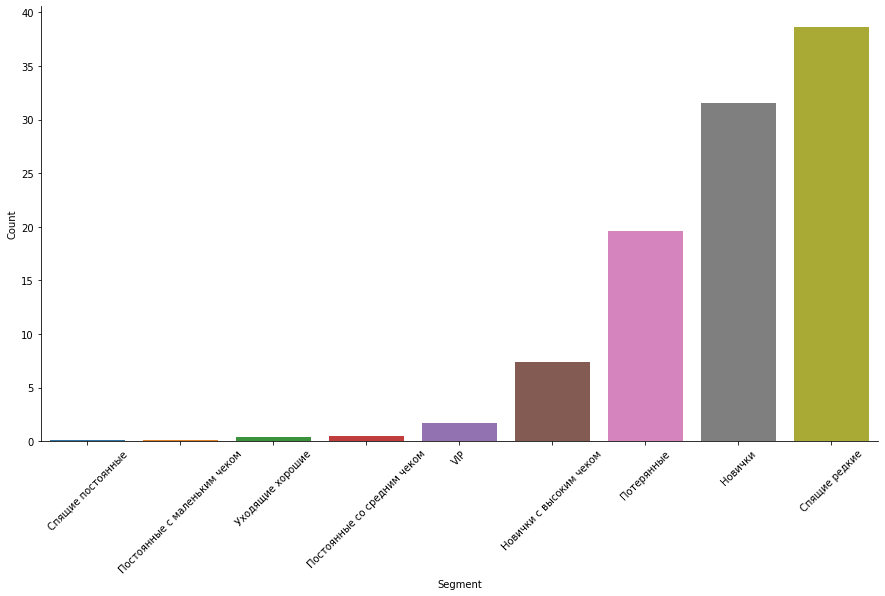

In [270]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x='Segment', y='Count', data=segment_count)
ax.set_xticklabels(segment_count.Segment, rotation=45)
sns.despine()

Вывод об анализе наших пользователей используя подход, основанный на сегментации. Большую часть пользователей занимают 'Спящие редкие' (39%), эти клиенты ещё помнят о нас, т.е. они совершали заказ относительно недавно. Для их удержания необходимо применять меры по заинтересованности, например, отправляем им рассылки с интересными акциями и выгодными предложениями. Также на нашем сайте много 'Новичков' и 'Новичков с высоким чеком' (32 и 7% соответственно). Это те пользователи, которые совершили свой первый заказ в течении последних 3 месяцев. Таким клиентам отправялем welcome-рассылку с описанием преимуществ, ответами на частые вопросы, материалы по работе с сайтом и тем, кто совершил заказ на большую сумму, можно сделать интересные предложения, чтобы превраттить их в постоянных клиентов. И 20% от наших пользователей занимают 'Потерянные', скорее всего, эти клиенты уже ушли от нас, и не стоит тратить слишком больших усилий на этот сегмент. Также у нас присутсвуют 1.7% пользователей, которые заняли сегмент 'VIP'. Таких клиентов нужно поддерживать выгодными для них предложениями, тогда они останутся с нами надолго, поэтому отправялем им особые предложения, например, участие в программе лояльности — приглашение в клуб любимых клиентов.